In [1]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils
plt.rcParams.update({"font.size": 20})

/opt/anaconda3/envs/pyg-coffea/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! ls ../Feb22_2017

DYJetsToLL_Pt-100To250                  TTToHadronic
DYJetsToLL_Pt-250To400                  TTToSemiLeptonic
DYJetsToLL_Pt-400To650                  VBFHToTauTau
DYJetsToLL_Pt-50To100                   VBFHToWWToLNuQQ_M-125_withDipoleRecoil
DYJetsToLL_Pt-650ToInf                  WJetsToLNu_HT-100To200
GluGluHToTauTau                         WJetsToLNu_HT-1200To2500
GluGluHToWWToLNuQQ                      WJetsToLNu_HT-200To400
GluGluHToWW_Pt-200ToInf_M-125           WJetsToLNu_HT-2500ToInf
HWminusJ_HToWW_M-125                    WJetsToLNu_HT-400To600
HWplusJ_HToWW_M-125                     WJetsToLNu_HT-600To800
HZJ_HToWW_M-125                         WJetsToLNu_HT-70To100

QCD_Pt_1400to1800                       WJetsToQQ_HT-200to400
QCD_Pt_170to300                         WJetsToQQ_HT-400to600
QCD_Pt_1800to2400                       WJetsToQQ_HT-600to800
QCD_Pt_2400to3200                       WJetsToQQ_HT-800toInf
QCD_Pt_300to470                         WW
QCD_Pt_3200toInf       

In [3]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttHToNonbb_M125",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [4]:
weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

In [5]:
def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

In [6]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]
tophad = ["fj_PN_probTopbWqq0c","fj_PN_probTopbWqq1c","fj_PN_probTopbWq0c","fj_PN_probTopbWq1c","fj_PN_probTopbWtauhv"]

top = tope+topm+tophad

# s/b

In [211]:
selections = {
    "mu": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
    },
}

In [212]:
samples_dir = "../Feb22_2017"
samples = os.listdir(samples_dir)

channels = ["mu"]

sigs = {
    "ele": hwwev,
    "mu": hwwmv,
}

qcd_bkg = [b.replace("PN","ParT") for b in qcd]
top_bkg = [b.replace("PN","ParT") for b in tope+topm+tophad]
inclusive_bkg = [b.replace("PN","ParT") for b in qcd+tope+topm+tophad]

events_dict = {}
for ch in channels:
    events_dict[ch] = {}

    new_sig = [s.replace("PN","ParT") for s in sigs[ch]]

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # get event_weight
    #     print(f"---> Retrieving event weight.")                
        event_weight = utils.get_xsecweight(pkl_files, "2017", sample, False, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
    #             print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]

        data["event_weight"] = event_weight
        
        # add QCD score 
        data["QCD"] = disc_score(data,new_sig,qcd_bkg)
        # add TOP score 
        data["Top"] = disc_score(data,new_sig,top_bkg)    
        # add inclusive score
        data["inclusive"] = disc_score(data,new_sig,inclusive_bkg)
            
        print(f"---> We have {len(data)} events.")        

        # apply selection
        for selection in selections[ch]:
            data = data.query(selections[ch][selection]) 
            print(f"---> Applied {selection}... Only {len(data)} events survived.")                    
 
            ### specify columns to keep
            columns_ = ["event_weight"]
            columns_ += ["fj_ParT_mass", "lep_fj_m"]  # to restrict s/b to a mass window
            columns_ += ["lep_pt", "lep_misolation"]  # for mini-isolation cuts
            columns_ += ["inclusive"]   # inclusive tagger score to cross check            

            # fill the big dataframe
            if sample_to_use not in events_dict[ch]:
                events_dict[ch][sample_to_use] = data[columns_]
            else:
                events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data[columns_]])

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> We have 964 events.
---> Applied pre-selection... Only 949 events survived.
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
---> We have 9908 events.
---> Applied pre-selection... Only 9814 events survived.
Finding VBFHToWWToLNuQQ_M-125_withDipoleRecoil samples and should combine them under VBF
---> We have 1177 events.
---> Applied pre-selection... Only 1150 events survived.
Finding HWminusJ_HToWW_M-125 samples and should combine them under VH
---> We have 12206 events.
---> Applied pre-selection... Only 11797 events survived.
Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> We have 203619 events.
---> Applied pre-selection... Only 198698 events survived.
Finding TTToSemiLeptonic samples and should combine them under TTbar
---> We have 885873 events.
---> Applied pre-selection... Only 861475 events survived.
Finding DYJetsToLL_Pt-250To400 sa

---> We have 99811 events.
---> Applied pre-selection... Only 99239 events survived.


In [213]:
events_dict.keys()

dict_keys(['mu'])

In [214]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'DYJets', 'VBF', 'VH', 'TTbar', 'SingleTop', 'HWW', 'WZQQ', 'QCD', 'Diboson', 'ttHToNonbb_M125'])

## Get cutflows and s/b

In [216]:
channels = ["mu"]

miso_cuts = [999999, 0.14, 0.18, 0.20, 0.22, 0.26]

cutflows = {}
for sample in events_dict["mu"]:
    cutflows[sample] = {}

s, b = {}, {}
for miso_cut in miso_cuts:
    if miso_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"

    s[cut_label], b[cut_label] = 0, 0

    for ch in channels:   # sum over channels (in this case only "mu")
        for sample in events_dict[ch]:

            df = events_dict[ch][sample]
            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
            df = df.loc[keep, :]
            
            ### cutflows
            cutflows[sample][cut_label] = len(df)

            ### mass window
            regressed_mass = df["fj_ParT_mass"]     
            lep_fj_m = df["lep_fj_m"]     
    #         mass_window = (regressed_mass>100) & (regressed_mass<150)
            mass_window = (lep_fj_m>0) & (lep_fj_m<150)

            ### s/b
            ev_weight = df["event_weight"]        
            if sample in signals:
                s[cut_label] += ev_weight[mass_window].sum()
            else:
                b[cut_label] += ev_weight[mass_window].sum()    

In [217]:
for miso_cut in s:
    print(f"{miso_cut} : s/b = {s[miso_cut]/math.sqrt(b[miso_cut])}")

pre-selection : s/b = 0.3494737775770448
pre-selection + mini-iso<0.14 : s/b = 0.47341634699440605
pre-selection + mini-iso<0.18 : s/b = 0.470089795231809
pre-selection + mini-iso<0.20 : s/b = 0.4698454334157826
pre-selection + mini-iso<0.22 : s/b = 0.46884724011475826
pre-selection + mini-iso<0.26 : s/b = 0.4632322567766893


In [218]:
for sample in cutflows:
    if sample in ["HWW", "WJetsLNu", "QCD", "TTbar"]:        
        print(sample)    
        for miso_cut in cutflows[sample]:
            print(f"{miso_cut} : {cutflows[sample][miso_cut]}")
        print("---------------------------------")            

WJetsLNu
pre-selection : 878975
pre-selection + mini-iso<0.14 : 851286
pre-selection + mini-iso<0.18 : 855729
pre-selection + mini-iso<0.20 : 857402
pre-selection + mini-iso<0.22 : 858762
pre-selection + mini-iso<0.26 : 860937
---------------------------------
TTbar
pre-selection : 1417841
pre-selection + mini-iso<0.14 : 1339957
pre-selection + mini-iso<0.18 : 1346958
pre-selection + mini-iso<0.20 : 1349669
pre-selection + mini-iso<0.22 : 1352113
pre-selection + mini-iso<0.26 : 1356401
---------------------------------
HWW
pre-selection : 14439
pre-selection + mini-iso<0.14 : 13561
pre-selection + mini-iso<0.18 : 13673
pre-selection + mini-iso<0.20 : 13729
pre-selection + mini-iso<0.22 : 13766
pre-selection + mini-iso<0.26 : 13836
---------------------------------
QCD
pre-selection : 78705
pre-selection + mini-iso<0.14 : 3595
pre-selection + mini-iso<0.18 : 4349
pre-selection + mini-iso<0.20 : 4778
pre-selection + mini-iso<0.22 : 5201
pre-selection + mini-iso<0.26 : 6194
--------------

In [219]:
## OTHERS
print("Counting events of the following samples:")
c = [0] * len(cutflows[sample])
for sample in cutflows:
    if sample not in ["HWW", "QCD", "TTbar", "WJetsLNu"]:
        if sample not in signals:
            print(sample)
            for i, miso_cut in enumerate(cutflows[sample]):
                c[i] += cutflows[sample][miso_cut]
print("---------------------------------")  
for i, miso_cut in enumerate(cutflows[sample]):
    print(f"{miso_cut}: {c[i]}")

Counting events of the following samples:
DYJets
SingleTop
WZQQ
Diboson
---------------------------------
pre-selection: 461741
pre-selection + mini-iso<0.14: 403845
pre-selection + mini-iso<0.18: 406031
pre-selection + mini-iso<0.20: 407065
pre-selection + mini-iso<0.22: 407997
pre-selection + mini-iso<0.26: 409736


# s/b as a function of the tagger cut

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


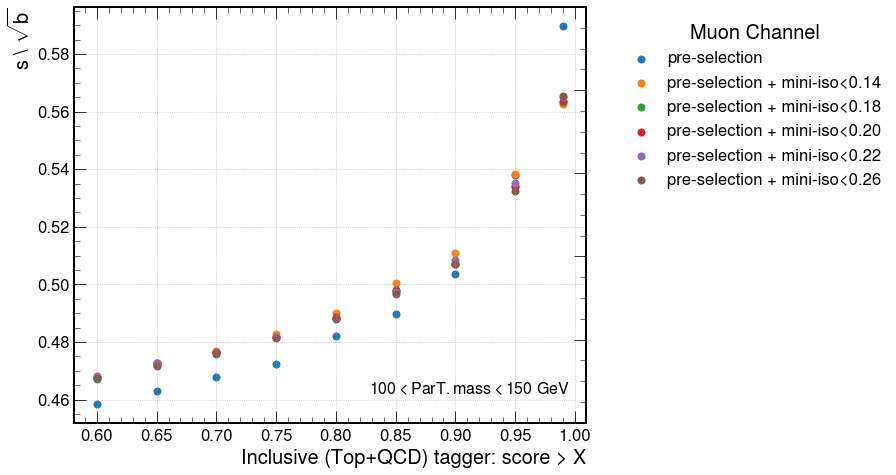

In [220]:
plt.rcParams.update({"font.size": 20})
channels = ["mu"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

miso_cuts = [999999, 0.14, 0.18, 0.20, 0.22, 0.26]
for miso_cut in miso_cuts:
    if miso_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"
    
    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive"]

            regressed_mass = df["fj_ParT_mass"]
            mass_window = (regressed_mass>100) & (regressed_mass<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$100<ParT.mass<150$ GeV", title_fontsize=16, loc=4)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


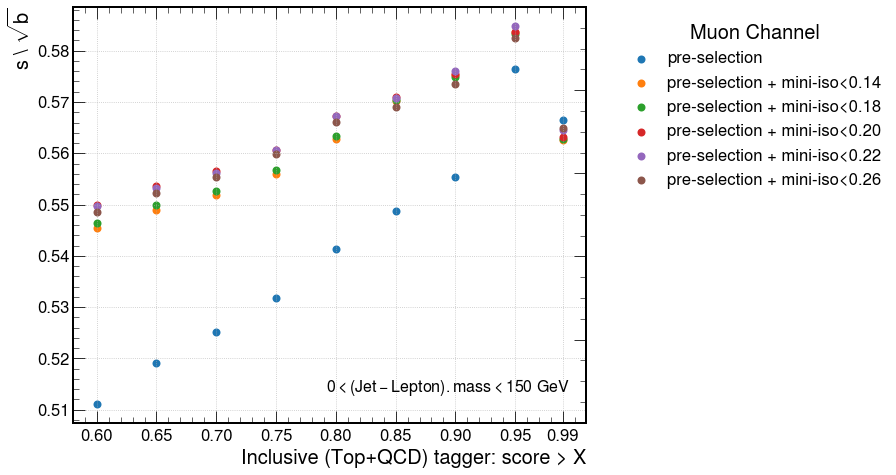

In [221]:
plt.rcParams.update({"font.size": 20})
channels = ["mu"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

miso_cuts = [999999, 0.14, 0.18, 0.20, 0.22, 0.26]
for miso_cut in miso_cuts:
    if miso_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mini-iso<{miso_cut:.2f}"
    
    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mini-isolation cut
            keep = ( ( df["lep_pt"]<55 ) | ( df["lep_pt"]>=55) & (df["lep_misolation"]<miso_cut ) )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive"]

            lep_fj_m = df["lep_fj_m"]
            mass_window = (lep_fj_m>0) & (lep_fj_m<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xticks(tagger_cuts)
ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$0<(Jet-Lepton).mass<150$ GeV", title_fontsize=16, loc=4)
plt.tight_layout()